## Import Library

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import os
import nltk
import joblib
import tensorflow as tf
from PyPDF2 import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, render_template, request

# Download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Dataset

In [ ]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/RextraProject/RextraProject/main/Machine%20Learning/Dataset.csv'
df = pd.read_csv(file_path)
df.head()

,ID,Kategori Umum,Kategori Khusus,Penyelenggara,Posisi,Deskripsi,Durasi,Tanggal Pendaftaran,Link,CP,Jenis Kontak,Lokasi,Persyaratan Pendaftaran,Skill yang didapat
0,1,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,"AIESEC, organisasi kepemimpinan pemuda global,...",1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Surabaya,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,- Strategic skill\n- Analytical skill\n- Komun...
1,2,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,"AIESEC, organisasi kepemimpinan pemuda global,...",1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Semarang,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,- Strategic skill\n- Analytical skill\n- Komun...
2,3,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,"AIESEC, organisasi kepemimpinan pemuda global,...",1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Jakarta Selatan,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,- Strategic skill\n- Analytical skill\n- Komun...
3,4,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,"AIESEC, organisasi kepemimpinan pemuda global,...",1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Bandung,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,- Strategic skill\n- Analytical skill\n- Komun...
4,5,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,"AIESEC, organisasi kepemimpinan pemuda global,...",1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Samarinda,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,- Strategic skill\n- Analytical skill\n- Komun...


In [ ]:
df.shape

(589, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       589 non-null    int64 
 1   Kategori Umum            589 non-null    object
 2   Kategori Khusus          589 non-null    object
 3   Penyelenggara            589 non-null    object
 4   Posisi                   589 non-null    object
 5   Deskripsi                589 non-null    object
 6   Durasi                   589 non-null    object
 7   Tanggal Pendaftaran      589 non-null    object
 8   Link                     589 non-null    object
 9   CP                       589 non-null    object
 10  Jenis Kontak             589 non-null    object
 11  Lokasi                   589 non-null    object
 12  Persyaratan Pendaftaran  589 non-null    object
 13  Skill yang didapat       589 non-null    object
dtypes: int64(1), object(13)
memory usage: 64.5

In [ ]:
df.isnull().sum()

ID                         0
Kategori Umum              0
Kategori Khusus            0
Penyelenggara              0
Posisi                     0
Deskripsi                  0
Durasi                     0
Tanggal Pendaftaran        0
Link                       0
CP                         0
Jenis Kontak               0
Lokasi                     0
Persyaratan Pendaftaran    0
Skill yang didapat         0
dtype: int64

In [ ]:
duplicate_counts = df.duplicated().sum()
print('Amount of duplicate data:')
print(duplicate_counts)

Amount of duplicate data:
0


## Preprocessing

In [ ]:
# Function to remove emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"
                                  u"\U000024C2-\U0001F251"
                                  "]+", flags=re.UNICODE)
    return emoticon_pattern.sub(r'', text).replace('\n\n', ' ')


In [ ]:
# Apply emoticon removal
df_clean = df.copy()
df_clean['Deskripsi'] = df_clean['Deskripsi'].apply(remove_emoticons)
df_clean['Skill yang didapat'] = df_clean['Skill yang didapat'].apply(remove_emoticons)

# Remove stopwords
stop = set(stopwords.words('indonesian'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop])

df_clean['Deskripsi'] = df_clean['Deskripsi'].apply(remove_stopwords)
df_clean['Skill yang didapat'] = df_clean['Skill yang didapat'].apply(remove_stopwords)

# Remove symbols and convert to lowercase
pattern = r'[$-/:-?{-~!"^_`\[\]]'
df_clean['Deskripsi'] = df_clean['Deskripsi'].str.replace(pattern, '', regex=True).str.lower()
df_clean['Skill yang didapat'] = df_clean['Skill yang didapat'].str.replace(pattern, '', regex=True).str.lower()

df_clean.head()

,ID,Kategori Umum,Kategori Khusus,Penyelenggara,Posisi,Deskripsi,Durasi,Tanggal Pendaftaran,Link,CP,Jenis Kontak,Lokasi,Persyaratan Pendaftaran,Skill yang didapat
0,1,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,aiesec organisasi kepemimpinan pemuda global m...,1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Surabaya,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,strategic skill analytical skill komunikasi...
1,2,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,aiesec organisasi kepemimpinan pemuda global m...,1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Semarang,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,strategic skill analytical skill komunikasi...
2,3,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,aiesec organisasi kepemimpinan pemuda global m...,1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Jakarta Selatan,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,strategic skill analytical skill komunikasi...
3,4,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,aiesec organisasi kepemimpinan pemuda global m...,1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Bandung,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,strategic skill analytical skill komunikasi...
4,5,Kegiatan Umum,Organisasi Luar Kampus,AIESEC,Staff,aiesec organisasi kepemimpinan pemuda global m...,1 tahun,10-26 Agustus 2024,https://aiesec.or.id/join-aiesec/,‪6281333553871‬,Whatsapp,Samarinda,- Mahasiswa D3/S1\n- Mahasiswa angkatan 2021-2...,strategic skill analytical skill komunikasi...


### Combine Relevant Columns

In [ ]:
# Combine relevant columns into one
df_clean['combined'] = df_clean['Deskripsi'] + ' ' + df_clean['Skill yang didapat']
df_clean['combined']

0      aiesec organisasi kepemimpinan pemuda global m...
1      aiesec organisasi kepemimpinan pemuda global m...
2      aiesec organisasi kepemimpinan pemuda global m...
3      aiesec organisasi kepemimpinan pemuda global m...
4      aiesec organisasi kepemimpinan pemuda global m...
                             ...                        
584    open recruitment volunteer itb mengajar 50 bua...
585    ukm expo wadah panggung ukm itb menampilkan ke...
586    itb premier cup proker eventual veteran jakart...
587    multimedia in action ajang kompetisi ksm multi...
588    bela negara festival belfest program kerja eve...
Name: combined, Length: 589, dtype: object

###Lemmatize Text Data

In [ ]:
# Define lemmatization function
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_clean['combined'] = df_clean['combined'].apply(lemmatize)

###Vectorize Text Data

In [ ]:
# Initialize vectorizer and calculate TF-IDF vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)
X = vectorizer.fit_transform(df_clean['combined']).toarray()

# Dummy target variable
y = np.random.randint(0, 2, X.shape[0])

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

##Train Neural Network Model

In [ ]:
from tensorflow.keras.regularizers import l2

# TensorFlow-based neural network model
def create_model(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4512 - loss: 4.1308 - val_accuracy: 0.4915 - val_loss: 3.3419
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5368 - loss: 3.1459 - val_accuracy: 0.5169 - val_loss: 2.5814
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5615 - loss: 2.4435 - val_accuracy: 0.5169 - val_loss: 2.0593
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5530 - loss: 1.9656 - val_accuracy: 0.5169 - val_loss: 1.7139
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5571 - loss: 1.6517 - val_accuracy: 0.5169 - val_loss: 1.4886
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5273 - loss: 1.4473 - val_accuracy: 0.5169 - val_loss: 1.3388
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5430 - loss: 1.3093 - val_accuracy: 0.5169 - val_loss: 1.2339
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5470 - loss: 1.2090 - val_accuracy: 0.5169 - val_loss: 1.1551
Epoc

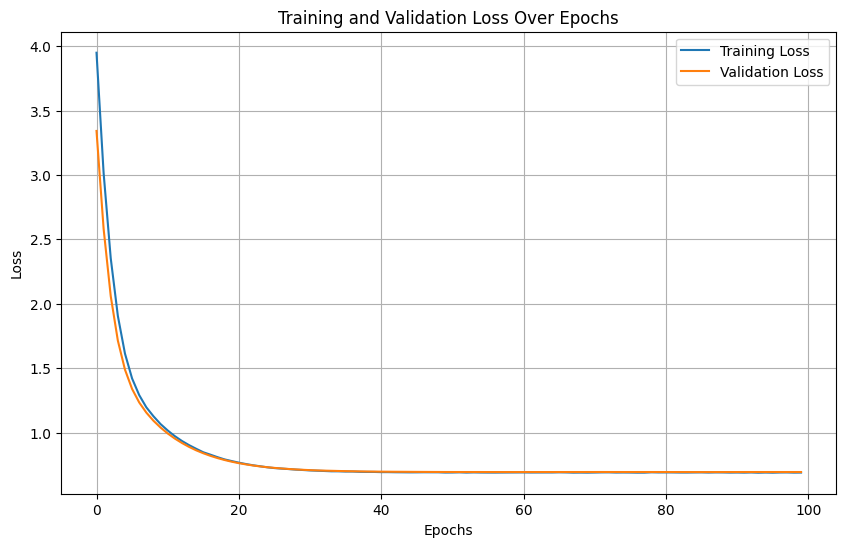

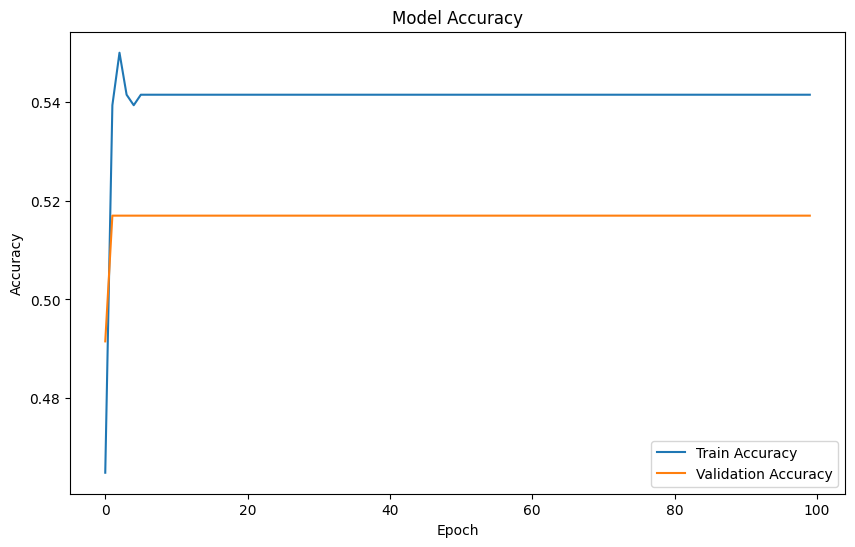

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# #Save the model
# saved_model_path = "./my_model.h5"
# model.save(saved_model_path)

# # Convert .h5 model to TensorFlow.js
# !tensorflowjs_converter --input_format=keras {saved_model_path} ./

# # Save vectorizer to file
# joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

2024-06-21 08:21:27.766250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


['tfidf_vectorizer.joblib']

##Recommendation Function

In [ ]:
# Function to clean user input
def clean_input(user_input):
    user_input = re.sub(r'[^\w\s]', '', user_input)
    user_input = user_input.lower()
    return user_input


In [ ]:
# Function to preprocess CV text
def preprocess_cv(text1):
    # Lowercase
    text1 = text1.lower()
    # Remove symbols
    pattern = r'[^A-Za-z\s]'
    text1 = re.sub(pattern, '', text1)
    # Remove stopwords
    stop = set(stopwords.words('english'))
    text1 = ' '.join([word for word in text1.split() if word not in stop])
    return text1

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text = ''
    try:
        with open(file_path, 'rb') as file:
            reader = PdfReader(file)
            num_pages = len(reader.pages)
            for page_num in range(num_pages):
                text += reader.pages[page_num].extract_text()
    except Exception as e:
        print(f"Error reading PDF file '{file_path}': {str(e)}")
    return text


In [ ]:
def recommend_activities(user_preference, penyelenggara, durasi, user_skills, user_past_activities, preprocessed_cv, top_n=3):
    # Filter based on general preference
    if user_preference.lower() == 'dalam kampus':
        filtered_df = df_clean[df_clean['Kategori Umum'] == 'Kegiatan Intra Kampus']
        # Further filter by penyelenggara if specified
        if penyelenggara:
            filtered_df = filtered_df[filtered_df['Penyelenggara'] == penyelenggara]
    else:
        filtered_df = df_clean[df_clean['Kategori Umum'] == 'Kegiatan Umum']
        # Further filter by penyelenggara if specified
        if penyelenggara:
            filtered_df = filtered_df[filtered_df['Penyelenggara'] == penyelenggara]

    # Further filter by kategori khusus if specified
    if user_kategori_khusus:
        filtered_df = filtered_df[filtered_df['Kategori Khusus'] == user_kategori_khusus]

    # Further filter by durasi if specified
    if durasi:
        filtered_df = filtered_df[filtered_df['Durasi'] == durasi]

    if filtered_df.empty:
        return []

    filtered_combined = filtered_df['combined']
    filtered_vectors = vectorizer.transform(filtered_combined)

    # Vectorize user inputs and CV
    user_input_vector = vectorizer.transform([f"{user_preference} {user_skills} {user_past_activities}"])
    cv_vector = vectorizer.transform([preprocessed_cv])

    # Combine vectors
    user_combined_vector = user_input_vector + cv_vector

    # Calculate cosine similarity
    similarity_scores = cosine_similarity(user_combined_vector, filtered_vectors).flatten()

    # Get the top N recommendations with similarity score above threshold
    top_indices = [index for index in similarity_scores.argsort()[::-1] if similarity_scores[index] > 0.1][:top_n]

    recommendations = []
    for index in top_indices:
        recommendations.append({
            'ID': filtered_df.iloc[index]['ID'],
            'Posisi': filtered_df.iloc[index]['Posisi'] if 'Posisi' in filtered_df.columns else 'N/A',
            'Penyelenggara': filtered_df.iloc[index]['Penyelenggara'] if 'Penyelenggara' in filtered_df.columns else 'N/A',
            'Deskripsi': filtered_df.iloc[index]['Deskripsi'],
            'Durasi': filtered_df.iloc[index]['Durasi'],
            'Persyaratan': filtered_df.iloc[index]['Persyaratan Pendaftaran'] if 'Persyaratan Pendaftaran' in filtered_df.columns else 'N/A',
            'Skill': filtered_df.iloc[index]['Skill yang didapat'],
            'Lokasi': filtered_df.iloc[index]['Lokasi'] if 'Lokasi' in filtered_df.columns else 'N/A',
            'Similarity Score': similarity_scores[index]
        })
    return recommendations


In [ ]:
# Example usage
if __name__ == "__main__":
    # Definisikan preferensi pengguna dan informasi CV
    penyelenggara = 'UPN Veteran Jakarta'
    user_preference = 'dalam kampus'
    durasi = '1 tahun'
    user_skills = 'data science'
    user_past_activities = 'ketua bem'
    cv_file_path = './CV_Irmaya Salsabila.pdf'

    # Ekstrak teks dari file CV
    cv_text = extract_text_from_pdf(cv_file_path)

    # Lakukan preprocessing teks CV
    preprocessed_cv = preprocess_cv(cv_text)

    # Panggil fungsi recommend_activities dengan semua argumen yang dibutuhkan
    recommendations = recommend_activities(user_preference, penyelenggara, durasi, user_skills, user_past_activities, preprocessed_cv)

    # Print hasil rekomendasi
    print("Rekomendasi Kegiatan:")
    for idx, recommendation in enumerate(recommendations, 1):
        print(f"{idx}. ID: {recommendation['ID']}")
        print(f"   Posisi: {recommendation['Posisi']}")
        print(f"   Penyelenggara: {recommendation['Penyelenggara']}")
        print(f"   Deskripsi: {recommendation['Deskripsi']}")
        print(f"   Durasi: {recommendation['Durasi']}")
        print(f"   Persyaratan: {recommendation['Persyaratan']}")
        print(f"   Skill yang didapat: {recommendation['Skill']}")
        print(f"   Lokasi: {recommendation['Lokasi']}")
        print(f"   Similarity Score: {recommendation['Similarity Score']}")
        print()

Rekomendasi Kegiatan:
1. ID: 442
   Posisi: KSM Android
   Penyelenggara: UPN Veteran Jakarta
   Deskripsi: ksm android kelompok studi mahasiswa fakultas ilmu komputer upnvj berfungsi wadah pembelajaran mahasiswa fik mengembangkan potensi kemampuan mahasiswa bidang pemrograman komputer mobile apps android development web development backend development uiux design data science project management
   Durasi: 1 tahun
   Persyaratan: - Mahasiswa aktif Fakultas Ilmu Komputer UPNVJ angkatan 2021, 2022, dan 2023.
- Sertifikat LDKMM wajib dilampirkan.
- Pastikan pengisian formulir pendaftaran selesai tepat waktu.
- Bersedia dan berkomitmen untuk mengikuti semua tahapan Open Recruitment Anggota Baru KSM Android 2024.
- Menunjukkan dedikasi yang tulus untuk memberikan kontribusi berharga kepada KSM Android.
- Memiliki minat di bidang teknologi dan motivasi untuk berkembang bersama.
   Skill yang didapat:  android development  web development  backend development  uiux design  data science  proje